In [1]:
%matplotlib inline

%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, "..")
import bettermoments as bm

In [3]:
def gaussian_model(params, x):
    return params[0] * np.exp(-0.5*(x - params[1])**2*np.exp(-2*params[2]))
    
def fit_gaussian(y):
    x = np.arange(len(y))
    def resid(params):
        return y - gaussian_model(params, x)
    
    res = op.leastsq(resid, (np.max(y), np.argmax(y), 0.0))
    return res[0]

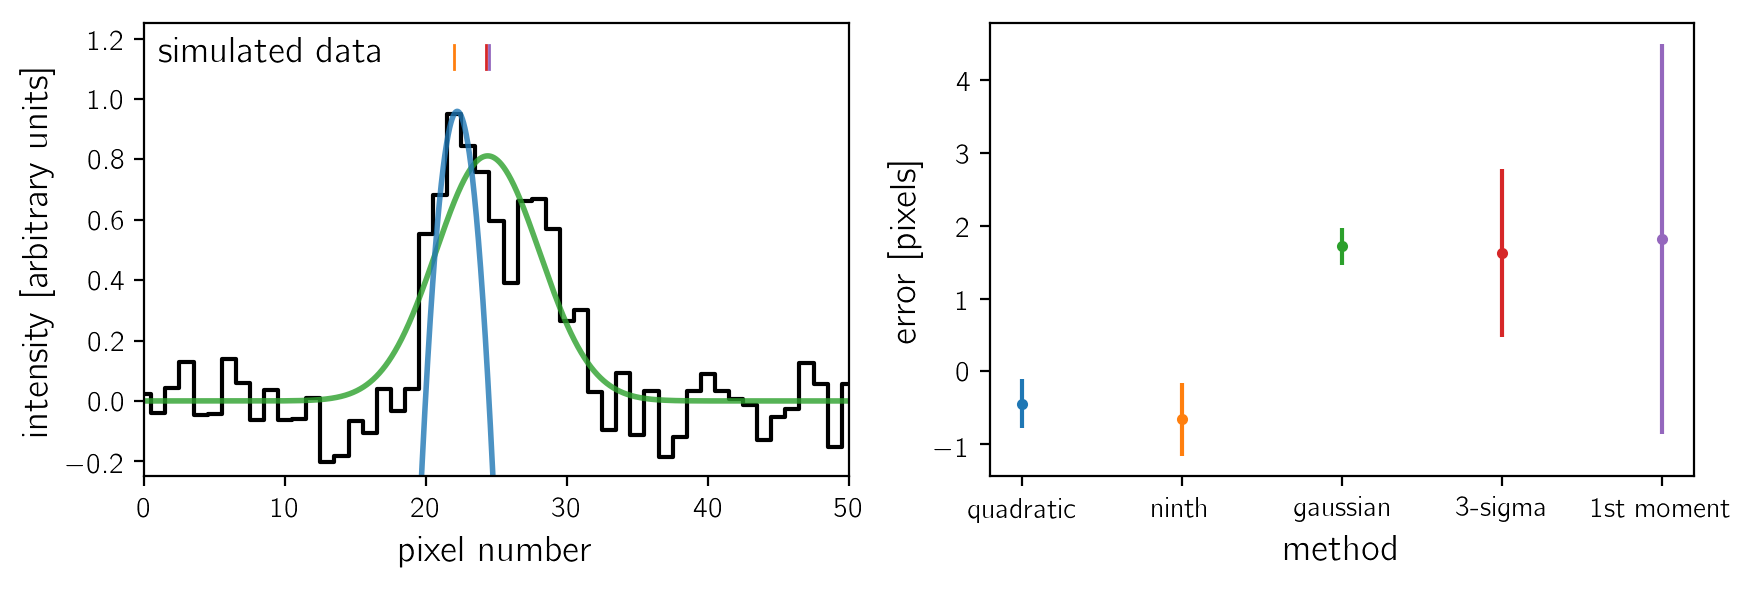

In [4]:
# Simulated data
np.random.seed(42)
x = np.arange(51)
x_true = 22.6614
y = gaussian_model([1.0, x_true, np.log(2.0)], x)
y += gaussian_model([0.7, 28.123, np.log(1.5)], x)
y += 1e-3 * (x - 0.5*len(x))
yerr = 0.1
y += yerr*np.random.randn(len(y))

# Fit the Gaussian
g_params = fit_gaussian(y)
x = np.linspace(0, len(y), 5000)
gauss_model = gaussian_model(g_params, x)
x_gauss = g_params[1]

eps = 1e-5
ll = lambda val: -0.5*np.sum(((y - gaussian_model([g_params[0], val, g_params[2]],
                                                  np.arange(len(y))))/yerr)**2)
ll_max = ll(x_gauss)
ll_plus = ll(x_gauss+eps)
ll_minus = ll(x_gauss-eps)
d2ll = (ll_plus + ll_minus - 2*ll_max) / eps**2
x_gauss_sig = 1.0 / np.sqrt(-d2ll)

# Fit the parabola
x0 = np.argmax(y)

f_minus = y[x0-1]
f_max = y[x0]
f_plus = y[x0+1]

a0 = f_max
a1 = 0.5 * (f_plus - f_minus)
a2 = 0.5 * (f_plus + f_minus - 2*f_max)

poly_model = a0 + a1*(x-x0) + a2*(x-x0)**2

x_max = x0 - 0.5 * a1 / a2
x_max_sig = yerr*np.sqrt((0.125*a1**2 + 0.375*a2**2)/a2**4)

# First moment estimate
A = np.sum(np.arange(len(y)) * y)
B = np.sum(y)
x_mom = A / B
x_mom_sig = yerr * np.sqrt(np.sum(y**2) / B**2 + len(y)*A**2/B**4)

# Sigma clipped moment estimate
sigma = np.sqrt(np.median((y - np.median(y))**2))
mask = np.abs(y - np.median(y)) > 3*sigma
A = np.sum(np.arange(len(y))[mask] * y[mask])
B = np.sum(y[mask])
x_clip = A / B
x_clip_sig = yerr * np.sqrt(np.sum(y[mask]**2) / B**2 + mask.sum()*A**2/B**4)

# Plot data and fits
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax = ax1
ax.step(np.arange(len(y)), y, color="k", where="mid")
ax.plot(x, gauss_model, lw=2, color="C2", alpha=0.8)
ax.plot(x, poly_model, lw=2, color="C0", alpha=0.8)

ax.set_ylim(-0.25, 1.25)
ax.set_xlim(0, len(y)-1)

ax.set_xlabel("pixel number", fontsize=13)
ax.set_ylabel("intensity [arbitrary units]", fontsize=13)
ax.annotate("simulated data", xy=(0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            ha="left", va="top", fontsize=13)

# Plot residuals
ax = ax2

names = ["quadratic", "ninth", "gaussian", "3-sigma", "1st moment"]
values = [x_max, x0, x_gauss, x_clip, x_mom]
sigmas = [x_max_sig, 0.5, x_gauss_sig, x_clip_sig, x_mom_sig]
ytick_coords = [1.1, 1.18]

for i, (v, sig) in enumerate(zip(values, sigmas)):
    color = "C{0}".format(i)
    fmt = "."
    
    ax.errorbar([i], [v - x_true], yerr=sig, fmt=fmt, color=color)

    if names[i] not in ("gaussian", "quadratic"):
        ax1.plot([v, v], ytick_coords, color=color, lw=1)

ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)

ax.set_ylabel("error [pixels]", fontsize=13)
ax.set_xlabel("method", fontsize=13)

fig.savefig("simulated-spectrum.pdf", bbox_inches="tight")

In [5]:
assert np.allclose((x_max, x_max_sig), bm.quadratic(y, yerr)[:2])

In [6]:
assert np.allclose((x_max, x_max_sig), bm.quadratic(y, yerr + np.zeros_like(y))[:2])

In [7]:
(x_max, x_max_sig), bm.quadratic(y, yerr + np.zeros_like(y))

((22.214800684209816, 0.3352084602923906),
 (array(22.21480068), array(0.33520846), array(0.95889263), array(0.10119951)))